### Random Forest Model to Predict Next Quarter Bookings

#### This was our final model that proved to be the most predictive and had the highest r2 value and lowest MAE

Loading data...

Unique Fiscal Quarters in data:
['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4', '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2024-Q2']
Creating quarterly features...

Quarterly DataFrame Head:
  fiscal_quarter  predicted_bookings  total_bookings  bookings_lag_1  \
4        2016-Q4        1.415906e+08    1.337013e+08    1.341879e+08   
5        2017-Q1        1.124180e+08    1.415906e+08    1.337013e+08   
6        2017-Q2        1.156511e+08    1.124180e+08    1.415906e+08   
7        2017-Q3        9.387953e+07    1.156511e+08    1.124180e+08   
8        2017-Q4        1.059243e+08    9.387953e+07    1.156511e+08   

   bookings_lag_2  bookings_lag_3  total_backlog  total_pipeline  \
4    1

C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Plotting results...


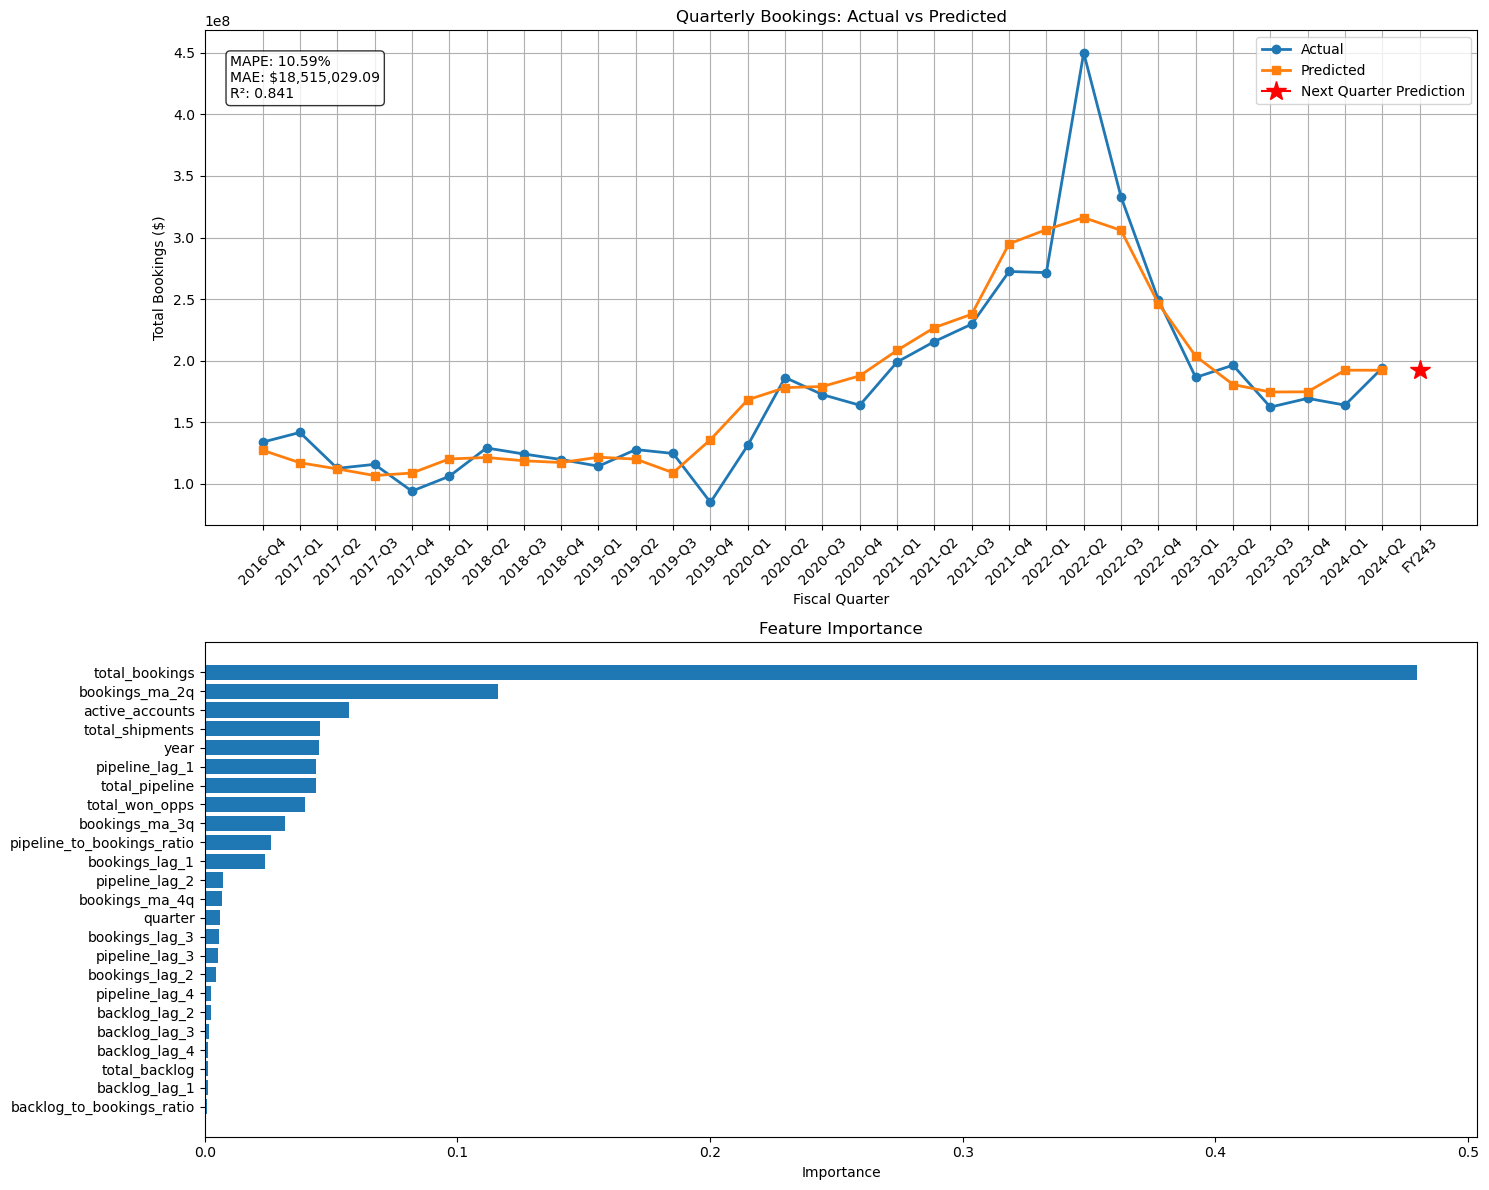


Quarterly Results:
    Quarter        Actual     Predicted  Absolute_Error  Percentage_Error
4   2016-Q4  1.337013e+08  1.271454e+08    6.555915e+06          4.903404
5   2017-Q1  1.415906e+08  1.169648e+08    2.462577e+07         17.392240
6   2017-Q2  1.124180e+08  1.119661e+08    4.519373e+05          0.402015
7   2017-Q3  1.156511e+08  1.065633e+08    9.087756e+06          7.857908
8   2017-Q4  9.387953e+07  1.085926e+08    1.471306e+07         15.672282
9   2018-Q1  1.059243e+08  1.200433e+08    1.411899e+07         13.329321
10  2018-Q2  1.289744e+08  1.212190e+08    7.755382e+06          6.013119
11  2018-Q3  1.240625e+08  1.185673e+08    5.495214e+06          4.429392
12  2018-Q4  1.195845e+08  1.171244e+08    2.460118e+06          2.057221
13  2019-Q1  1.141536e+08  1.214706e+08    7.317041e+06          6.409823
14  2019-Q2  1.276700e+08  1.199183e+08    7.751727e+06          6.071689
15  2019-Q3  1.245039e+08  1.088388e+08    1.566510e+07         12.582012
16  2019-Q4  8.476

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import xgboost as xgb

def load_and_prepare_data(target_quarter='2024-Q3'):
    """
    Load and prepare the revenue forecast data for analysis up to a target quarter.
    
    Args:
        target_quarter: String representing the last quarter to include (format: 'YYYY-QN')
                       Default is '2024-Q3'
    
    Returns:
        DataFrame: Processed and sorted dataset with additional time-based features
    """
    # Load the raw data from CSV file into a pandas DataFrame
    load_df = pd.read_csv('Revenue Forecast.csv')
    
    # Filter data to include only quarters before the target quarter
    # Reset index to ensure clean integer indexing after filtering
    load_df = load_df.loc[load_df['FISCAL_YEAR_QUARTER_NAME'] < target_quarter].reset_index()
    
    # Create a deep copy to avoid modifying original data
    # This ensures data integrity and prevents unwanted side effects
    df = deepcopy(load_df)
    
    # Extract quarter number (1-4) from the quarter name
    # Example: 'FY22Q1' -> 1
    df['QUARTER'] = df['FISCAL_YEAR_QUARTER_NAME'].str[-1].astype(int)
    
    # Extract two-digit year from the quarter name
    # Example: 'FY22Q1' -> 22
    df['YEAR'] = df['FISCAL_YEAR_QUARTER_NAME'].str[2:4].astype(int)
    
    # Convert fiscal quarter names to datetime objects for proper sorting
    # Lambda function converts 'FY22Q1' to '2022-03-01' (Q1=month 3, Q2=month 6, etc.)
    df['FISCAL_QUARTER'] = pd.to_datetime(df['FISCAL_YEAR_QUARTER_NAME'].apply(
        lambda x: f"20{x[2:4]}-{(int(x[-1]) * 3):02d}-01"
    ))
    
    # Sort the DataFrame chronologically by fiscal quarter
    df = df.sort_values('FISCAL_QUARTER')
    
    # Print unique quarters in the dataset for verification
    print("\nUnique Fiscal Quarters in data:")
    print(sorted(df['FISCAL_YEAR_QUARTER_NAME'].unique()))
    
    return df

def create_quarterly_features(df):
    """
    Create aggregated quarterly features from the input DataFrame.
    
    This function groups data by fiscal quarters and computes various features such as:
    - Bookings (predicted, actual, and historical)
    - Pipeline and backlog metrics
    - Won opportunities
    - Shipment amounts
    - Account activity
    - Moving averages and ratios
    
    Args:
        df: Input DataFrame containing raw financial data
        
    Returns:
        DataFrame: Aggregated quarterly data with derived features
    """
    # Initialize list to store quarterly aggregated data
    quarterly_data = []
    
    # Group data by fiscal quarter for aggregation
    grouped = df.groupby('FISCAL_YEAR_QUARTER_NAME')
    
    # Process each quarter's data
    for quarter, quarter_data in grouped:
        # Create dictionary of aggregated metrics for this quarter
        quarter_dict = {
            # Quarter identifier
            'fiscal_quarter': quarter,
            
            # Booking metrics
            'predicted_bookings': quarter_data['NEXT_QUARTER_BKGS_AMT_PREDIC'].sum(),
            'total_bookings': quarter_data['FISCAL_QUARTER_BKGS_AMT'].sum(),
            
            # Historical booking amounts (last 3 quarters)
            'bookings_lag_1': quarter_data['PRIOR_QUARTER_BOOKINGS_AMT'].sum(),
            'bookings_lag_2': quarter_data['TWO_QUARTER_BACK_BOOKINGS_AMT'].sum(),
            'bookings_lag_3': quarter_data['THREE_QUARTER_BACK_BOOKINGS_AMT'].sum(),
            
            # Revenue pipeline metrics
            'total_backlog': quarter_data['BACKLOG_REV_END_OF_QTR'].sum(),
            'total_pipeline': quarter_data['OPEN_OPPS_AMT_END_OF_FISCAL_QTR'].sum(),
            
            # Combined won opportunities (new + existing)
            # Note: Combined metric proved more predictive than separate components
            'total_won_opps': (quarter_data['OPPS_AMT_WON_IN_FISCAL_QTR_AND_OPEN_PRIOR_FISCAL_QTR'].sum() +
                             quarter_data['NEW_OPPS_AMT_WON_IN_FISCAL_QTR'].sum()),
            
            # Shipment and account metrics
            'total_shipments': quarter_data['FISCAL_QUARTER_TOTAL_SHIP_AMT'].sum(),
            'active_accounts': len(quarter_data['ACCOUNT_ID'].unique()),
            
            # Time components
            'quarter': int(quarter[-1]),  # Quarter number (1-4)
            'year': int(quarter[2:4])     # Two-digit year
        }
        quarterly_data.append(quarter_dict)
    
    # Convert list of dictionaries to DataFrame
    quarterly_df = pd.DataFrame(quarterly_data)
    
    # Sort by fiscal quarter for time series consistency
    quarterly_df = quarterly_df.sort_values('fiscal_quarter')
    
    # Create lagged features for backlog and pipeline
    # These capture historical trends up to 4 quarters back
    for i in range(1, 5):
        quarterly_df[f'backlog_lag_{i}'] = quarterly_df['total_backlog'].shift(i)
        quarterly_df[f'pipeline_lag_{i}'] = quarterly_df['total_pipeline'].shift(i)
    
    # Calculate moving averages for bookings
    # These smooth out seasonal variations and capture longer-term trends
    quarterly_df['bookings_ma_2q'] = quarterly_df['total_bookings'].rolling(2).mean()
    quarterly_df['bookings_ma_3q'] = quarterly_df['total_bookings'].rolling(3).mean()
    quarterly_df['bookings_ma_4q'] = quarterly_df['total_bookings'].rolling(4).mean()
    
    # Calculate ratio metrics
    # Replace 0 with 1 in denominator to avoid division by zero errors
    quarterly_df['pipeline_to_bookings_ratio'] = quarterly_df['total_pipeline'] / quarterly_df['total_bookings'].replace(0, 1)
    quarterly_df['backlog_to_bookings_ratio'] = quarterly_df['total_backlog'] / quarterly_df['total_bookings'].replace(0, 1)
    
    # Remove rows with missing values (typically first few quarters due to lag calculations)
    quarterly_df = quarterly_df.dropna()
    
    # Print sample of processed data for verification
    print("\nQuarterly DataFrame Head:")
    print(quarterly_df.head())
    
    return quarterly_df

def train_and_predict(quarterly_df):
    """
    Train model on historical data and make predictions for all quarters including the next quarter.
    
    Args:
        quarterly_df: DataFrame containing quarterly aggregated features
        
    Returns:
        tuple: (historical predictions, next quarter prediction, feature importance scores, feature names)
    """
    # Create list of feature columns, excluding the target and identifier columns
    feature_cols = [col for col in quarterly_df.columns if col not in
                   ['fiscal_quarter', 'predicted_bookings']]
    
    # Prepare feature matrix and target vector
    X = quarterly_df[feature_cols]  # All features for predictions
    X_sub_1 = X.iloc[:-1]          # Remove last row for training (we don't have its target yet)
    y = quarterly_df['predicted_bookings']
    y = y.iloc[:-1]                # Remove last row's target value
    
    # Initialize and apply StandardScaler to normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)                # Scale all data for predictions
    X_sub_scaled = scaler.fit_transform(X_sub_1)      # Scale training data
    
    # Initialize Random Forest model with specific hyperparameters
    model = RandomForestRegressor(
        n_estimators=200,        # Number of trees in the forest
        max_depth=20,           # Maximum depth of each tree
        min_samples_split=5,    # Minimum samples required to split a node
        random_state=42         # Seed for reproducibility
    )
    
    # Train model on historical data
    model.fit(X_sub_scaled, y)
    
    # Generate predictions for all historical quarters
    predictions = model.predict(X_scaled)
    
    # Prepare features for next quarter prediction
    last_quarter = quarterly_df.iloc[-1]
    next_quarter_features = last_quarter[feature_cols].copy()
    
    # Update time-based features for next quarter
    next_quarter_features['quarter'] = (last_quarter['quarter'] % 4) + 1  # Cycle through quarters 1-4
    # Increment year if rolling over to Q1
    next_quarter_features['year'] = last_quarter['year'] + (1 if next_quarter_features['quarter'] == 1 else 0)
    
    # Scale and predict next quarter's bookings
    next_quarter_scaled = scaler.transform(next_quarter_features.values.reshape(1, -1))
    next_quarter_prediction = model.predict(next_quarter_scaled)[0]
    
    return predictions, next_quarter_prediction, model.feature_importances_, feature_cols

def plot_results(quarterly_df, predictions, next_quarter_prediction, feature_importance, feature_cols):
    """
    Visualize model results including historical predictions, next quarter prediction, and feature importance.
    
    Args:
        quarterly_df: DataFrame with historical data
        predictions: Array of historical predictions
        next_quarter_prediction: Predicted value for next quarter
        feature_importance: Array of feature importance scores
        feature_cols: List of feature names
    """
    # Create figure with two vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Extract data for plotting
    quarters = quarterly_df['fiscal_quarter']
    actuals = quarterly_df['total_bookings']
    
    # Plot 1: Time series of actual vs predicted values
    ax1.plot(quarters, actuals, marker='o', label='Actual', linewidth=2)
    ax1.plot(quarters, predictions, marker='s', label='Predicted', linewidth=2)
    
    # Add next quarter prediction point
    # Calculate next quarter name (e.g., 'FY22Q1')
    next_quarter_name = f"FY{int(quarterly_df['year'].iloc[-1])}{(quarterly_df['quarter'].iloc[-1] % 4) + 1}"
    ax1.plot(next_quarter_name, next_quarter_prediction, marker='*', markersize=15,
             color='red', label='Next Quarter Prediction')
    
    # Customize first plot
    ax1.set_title('Quarterly Bookings: Actual vs Predicted')
    ax1.set_xlabel('Fiscal Quarter')
    ax1.set_ylabel('Total Bookings ($)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True)
    
    # Calculate and display performance metrics
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100  # Mean Absolute Percentage Error
    mae = np.mean(np.abs(actuals - predictions))                      # Mean Absolute Error
    r2 = 1 - (np.sum((actuals - predictions) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))  # R-squared
    
    # Add metrics text box
    metrics_text = f'MAPE: {mape:.2f}%\nMAE: ${mae:,.2f}\nR²: {r2:.3f}'
    ax1.text(0.02, 0.95, metrics_text, transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Feature importance bar chart
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    ax2.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    ax2.set_title('Feature Importance')
    ax2.set_xlabel('Importance')
    
    # Adjust subplot spacing
    plt.tight_layout()
    plt.show()
    
    # Print detailed quarterly results
    print("\nQuarterly Results:")
    results_df = pd.DataFrame({
        'Quarter': quarterly_df['fiscal_quarter'],
        'Actual': actuals,
        'Predicted': predictions,
        'Absolute_Error': np.abs(actuals - predictions),
        'Percentage_Error': np.abs((actuals - predictions) / actuals) * 100
    })
    print(results_df)
    
    print(f"\nNext Quarter ({next_quarter_name}) Prediction: ${next_quarter_prediction:,.2f}")

def main(quarter):
    """
    Main execution function that orchestrates the entire prediction pipeline.
    
    Args:
        quarter: Target quarter for analysis (format: 'YYYY-QN')
    """
    # Step 1: Load and prepare raw data
    print("Loading data...")
    df = load_and_prepare_data(quarter)
    
    # Step 2: Create aggregated quarterly features
    print("Creating quarterly features...")
    quarterly_df = create_quarterly_features(df)
    
    # Step 3: Train model and generate predictions
    print("Training model and making predictions...")
    predictions, next_quarter_prediction, feature_importance, feature_cols = train_and_predict(quarterly_df)
    
    # Step 4: Visualize and display results
    print("Plotting results...")
    plot_results(quarterly_df, predictions, next_quarter_prediction, feature_importance, feature_cols)

# Script entry point
quarter_list = ['2024-Q3']
if __name__ == "__main__":
    # Process each quarter in the list
    for quarter in quarter_list:
        main(quarter)

### xgBoost Model to Predict Next Quarter Bookings

#### This was our second most predictive model with the second highest r2 value and second lowest MAE

Loading data...

Unique Fiscal Quarters in data:
['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4', '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2024-Q2']
Creating quarterly features...

Quarterly DataFrame Head:
  fiscal_quarter  predicted_bookings  total_bookings  bookings_lag_1  \
4        2016-Q4        1.415906e+08    1.337013e+08    1.341879e+08   
5        2017-Q1        1.124180e+08    1.415906e+08    1.337013e+08   
6        2017-Q2        1.156511e+08    1.124180e+08    1.415906e+08   
7        2017-Q3        9.387953e+07    1.156511e+08    1.124180e+08   
8        2017-Q4        1.059243e+08    9.387953e+07    1.156511e+08   

   bookings_lag_2  bookings_lag_3  total_backlog  total_pipeline  \
4    1

C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


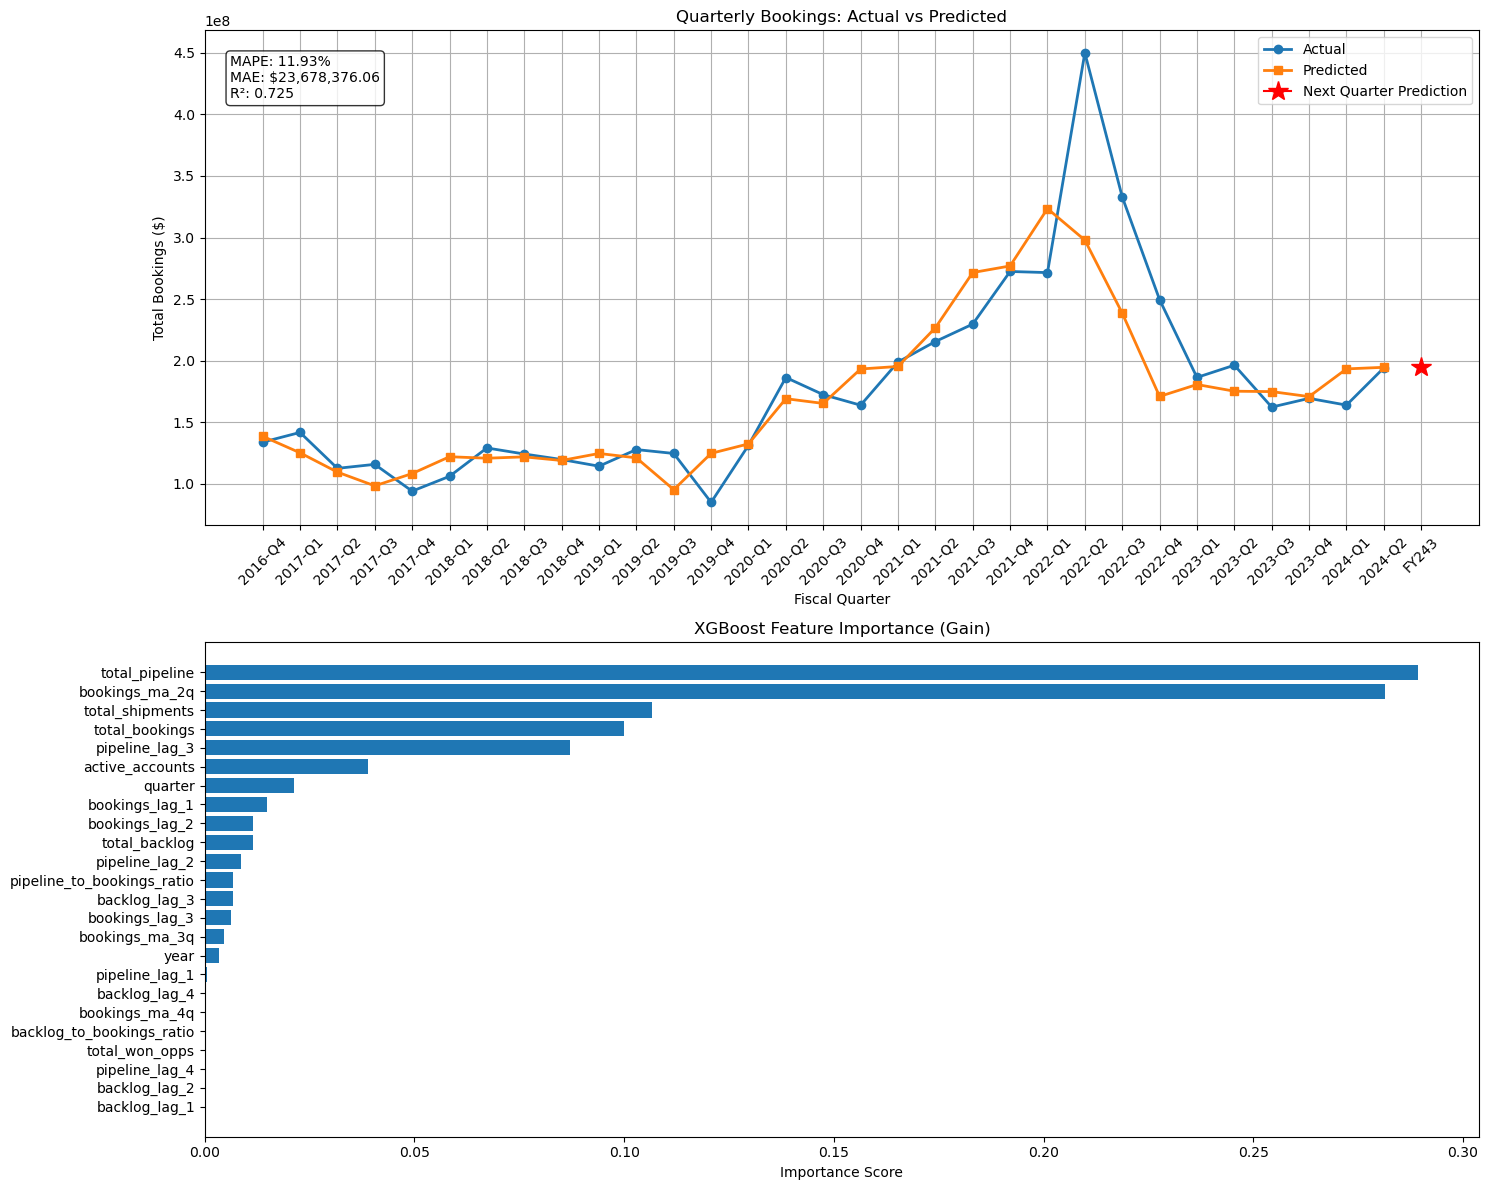


Quarterly Results:
    Quarter        Actual    Predicted  Absolute_Error  Percentage_Error
4   2016-Q4  1.337013e+08  138485344.0    4.784034e+06          3.578150
5   2017-Q1  1.415906e+08  125047152.0    1.654341e+07         11.683979
6   2017-Q2  1.124180e+08  109354512.0    3.063517e+06          2.725112
7   2017-Q3  1.156511e+08   98188328.0    1.746275e+07         15.099515
8   2017-Q4  9.387953e+07  108166152.0    1.428663e+07         15.218043
9   2018-Q1  1.059243e+08  121846720.0    1.592238e+07         15.031846
10  2018-Q2  1.289744e+08  120647544.0    8.326834e+06          6.456192
11  2018-Q3  1.240625e+08  121745960.0    2.316522e+06          1.867222
12  2018-Q4  1.195845e+08  118798528.0    7.859942e+05          0.657271
13  2019-Q1  1.141536e+08  124505648.0    1.035208e+07          9.068558
14  2019-Q2  1.276700e+08  120933976.0    6.736052e+06          5.276142
15  2019-Q3  1.245039e+08   95097552.0    2.940634e+07         23.618814
16  2019-Q4  8.476539e+07  1245

In [6]:
def train_and_predict(quarterly_df):
    """
    Train XGBoost model on historical data and make predictions for all quarters including next quarter.
    XGBoost typically provides better performance than Random Forest for this type of regression task.
    
    Args:
        quarterly_df: DataFrame containing quarterly aggregated features
        
    Returns:
        tuple: (historical predictions, next quarter prediction, feature importance scores, feature names)
    """
    # Create list of feature columns, excluding target and identifier columns
    feature_cols = [col for col in quarterly_df.columns if col not in
                   ['fiscal_quarter', 'predicted_bookings']]
    
    # Prepare feature matrices and target vector
    X = quarterly_df[feature_cols]                # All features for prediction
    X_sub_1 = X.iloc[:-1]                        # Remove last row for training
    y = quarterly_df['predicted_bookings']        # Target variable
    y = y.iloc[:-1]                              # Remove last row's target (unknown)
    
    # Initialize and apply StandardScaler for feature normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)           # Scale all data for predictions
    X_sub_scaled = scaler.fit_transform(X_sub_1) # Scale training data
    
    # Initialize XGBoost model with optimized hyperparameters
    model = xgb.XGBRegressor(
        n_estimators=200,        # Number of boosting rounds
        learning_rate=0.1,       # Step size shrinkage to prevent overfitting
        max_depth=6,             # Maximum tree depth
        min_child_weight=1,      # Minimum sum of instance weight in a child
        subsample=0.8,           # Fraction of samples used for tree building
        colsample_bytree=0.8,    # Fraction of features used for tree building
        random_state=42          # Seed for reproducibility
    )
    
    # Train model on historical data
    model.fit(X_sub_scaled, y)
    
    # Generate predictions for all historical quarters
    predictions = model.predict(X_scaled)
    
    # Prepare features for next quarter prediction
    last_quarter = quarterly_df.iloc[-1]
    next_quarter_features = last_quarter[feature_cols].copy()
    
    # Update time-based features for next quarter
    next_quarter_features['quarter'] = (last_quarter['quarter'] % 4) + 1  # Cycle through quarters 1-4
    # Increment year if rolling over to Q1
    next_quarter_features['year'] = last_quarter['year'] + (1 if next_quarter_features['quarter'] == 1 else 0)
    
    # Scale and predict next quarter's bookings
    next_quarter_scaled = scaler.transform(next_quarter_features.values.reshape(1, -1))
    next_quarter_prediction = model.predict(next_quarter_scaled)[0]
    
    # Get feature importance using XGBoost's built-in feature importance metric
    # This uses gain (improvement in accuracy) as the importance metric
    feature_importance = model.feature_importances_
    
    return predictions, next_quarter_prediction, feature_importance, feature_cols

def plot_results(quarterly_df, predictions, next_quarter_prediction, feature_importance, feature_cols):
    """
    Visualize model results including historical predictions, next quarter prediction, and feature importance.
    Includes performance metrics and detailed quarterly analysis.
    
    Args:
        quarterly_df: DataFrame with historical data
        predictions: Array of historical predictions
        next_quarter_prediction: Predicted value for next quarter
        feature_importance: Array of feature importance scores from XGBoost
        feature_cols: List of feature names
    """
    # Create figure with two vertically stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Extract data for plotting
    quarters = quarterly_df['fiscal_quarter']
    actuals = quarterly_df['total_bookings']
    
    # Plot 1: Time series comparison of actual vs predicted values
    ax1.plot(quarters, actuals, marker='o', label='Actual', linewidth=2)
    ax1.plot(quarters, predictions, marker='s', label='Predicted', linewidth=2)
    
    # Add next quarter prediction point
    # Calculate next quarter name (e.g., 'FY22Q1')
    next_quarter_name = f"FY{int(quarterly_df['year'].iloc[-1])}{(quarterly_df['quarter'].iloc[-1] % 4) + 1}"
    ax1.plot(next_quarter_name, next_quarter_prediction, marker='*', markersize=15,
             color='red', label='Next Quarter Prediction')
    
    # Customize first plot appearance
    ax1.set_title('Quarterly Bookings: Actual vs Predicted')
    ax1.set_xlabel('Fiscal Quarter')
    ax1.set_ylabel('Total Bookings ($)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True)
    
    # Calculate performance metrics
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100  # Mean Absolute Percentage Error
    mae = np.mean(np.abs(actuals - predictions))                      # Mean Absolute Error
    r2 = 1 - (np.sum((actuals - predictions) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))  # R-squared
    
    # Add metrics text box to plot
    metrics_text = f'MAPE: {mape:.2f}%\nMAE: ${mae:,.2f}\nR²: {r2:.3f}'
    ax1.text(0.02, 0.95, metrics_text, transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: XGBoost feature importance bar chart
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    ax2.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    ax2.set_title('XGBoost Feature Importance (Gain)')
    ax2.set_xlabel('Importance Score')
    
    # Adjust subplot spacing
    plt.tight_layout()
    plt.show()
    
    # Print detailed quarterly results table
    print("\nQuarterly Results:")
    results_df = pd.DataFrame({
        'Quarter': quarterly_df['fiscal_quarter'],
        'Actual': actuals,
        'Predicted': predictions,
        'Absolute_Error': np.abs(actuals - predictions),
        'Percentage_Error': np.abs((actuals - predictions) / actuals) * 100
    })
    print(results_df)
    
    # Print next quarter prediction
    print(f"\nNext Quarter ({next_quarter_name}) Prediction: ${next_quarter_prediction:,.2f}")

def main(target_quarter):
    """
    Main execution function that orchestrates the entire prediction pipeline.
    
    Args:
        target_quarter: Target quarter for analysis (format: 'YYYY-QN')
    """
    # Step 1: Load and prepare raw data
    print("Loading data...")
    df = load_and_prepare_data(target_quarter)
    
    # Step 2: Create aggregated quarterly features
    print("Creating quarterly features...")
    quarterly_df = create_quarterly_features(df)
    
    # Step 3: Train XGBoost model and generate predictions
    print("Training model and making predictions...")
    predictions, next_quarter_prediction, feature_importance, feature_cols = train_and_predict(quarterly_df)
    
    # Step 4: Visualize and display results
    print("Plotting results...")
    plot_results(quarterly_df, predictions, next_quarter_prediction, feature_importance, feature_cols)

# Script execution configuration and entry point
quarter_list = ['2024-Q3']
if __name__ == "__main__":
    # Process each quarter in the list
    for quarter in quarter_list:
        main(quarter)

### ARIMA Model to Predict Next Quarter Bookings


Unique Fiscal Quarters in data:
['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4', '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2024-Q2']
                                    SARIMAX Results                                    
Dep. Variable:                  total_bookings   No. Observations:                   35
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -576.636
Date:                         Wed, 20 Nov 2024   AIC                           1163.272
Time:                                 13:35:06   BIC                           1170.278
Sample:                             12-01-2015   HQIC                          1165.513
                                  - 06-01-2024       

C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\lodarih\AppData\Local\Temp\ipykernel_11616\3190047151.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = f

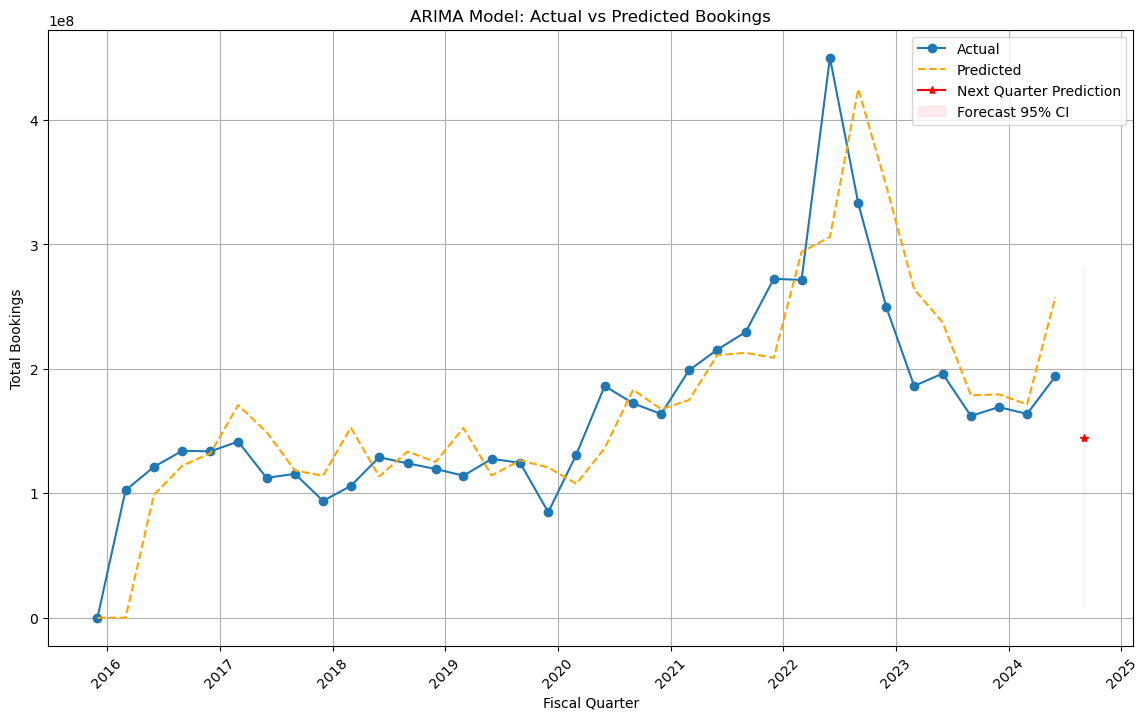

Next Quarter Prediction: $144,531,800.25
95% Confidence Interval: {'lower total_bookings': 7574208.657636881, 'upper total_bookings': 281489391.8495712}
Mean Absolute Error (MAE): $33,266,318.78
Mean Absolute Percentage Error (MAPE): 19.55%
R-squared (R2): 0.638


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

def load_and_prepare_data():
    """
    Load and prepare the revenue forecast data for ARIMA time series analysis.
    Includes date conversion and sorting for proper time series processing.
    
    Returns:
        DataFrame: Processed dataset with proper datetime index
    """
    # Load raw data from CSV file
    df = pd.read_csv('Revenue Forecast.csv')
    
    # Extract quarter (1-4) and year components from fiscal quarter name
    df['QUARTER'] = df['FISCAL_YEAR_QUARTER_NAME'].str[-1].astype(int)
    df['YEAR'] = df['FISCAL_YEAR_QUARTER_NAME'].str[2:4].astype(int)
    
    # Convert fiscal quarter names to proper datetime format
    # Example: 'FY22Q1' -> '2022-03-01' (Q1=month 3, Q2=month 6, etc.)
    df['FISCAL_QUARTER'] = pd.to_datetime(df['FISCAL_YEAR_QUARTER_NAME'].apply(
        lambda x: f"20{x[2:4]}-{(int(x[-1]) * 3):02d}-01"
    ))
    
    # Sort chronologically for time series analysis
    df = df.sort_values('FISCAL_QUARTER')
    
    # Display available quarters for verification
    print("\nUnique Fiscal Quarters in data:")
    print(sorted(df['FISCAL_YEAR_QUARTER_NAME'].unique()))
    
    return df

def create_quarterly_features_arima(df):
    """
    Aggregate data to quarterly level for ARIMA modeling.
    ARIMA requires regular time series data with consistent intervals.
    
    Args:
        df: Raw DataFrame with multiple entries per quarter
        
    Returns:
        DataFrame: Aggregated quarterly data with proper datetime index
    """
    # Group by fiscal quarter and sum bookings
    quarterly_df = df.groupby('FISCAL_YEAR_QUARTER_NAME')['FISCAL_QUARTER_BKGS_AMT'].sum().reset_index()
    
    # Rename column for clarity
    quarterly_df = quarterly_df.rename(columns={'FISCAL_QUARTER_BKGS_AMT': 'total_bookings'})
    
    # Convert fiscal quarter names to datetime for proper time series index
    quarterly_df['fiscal_quarter'] = pd.to_datetime(
        quarterly_df['FISCAL_YEAR_QUARTER_NAME'].apply(lambda x: f"20{x[2:4]}-{(int(x[-1]) * 3):02d}-01")
    )
    
    # Sort chronologically
    quarterly_df = quarterly_df.sort_values('fiscal_quarter')
    return quarterly_df

def train_arima_and_predict(quarterly_df):
    """
    Train ARIMA model and generate predictions including next quarter forecast.
    
    Args:
        quarterly_df: DataFrame with quarterly aggregated bookings
        
    Returns:
        tuple: (historical predictions, next quarter forecast, confidence intervals)
    """
    # Set datetime index for time series analysis
    quarterly_df.set_index('fiscal_quarter', inplace=True)
    
    # Extract target variable (bookings)
    y = quarterly_df['total_bookings']
    
    # Initialize and fit ARIMA model
    # Parameters: (p,d,q) = (1,1,1) for non-seasonal component
    # (P,D,Q,s) = (1,1,1,4) for seasonal component (s=4 for quarterly data)
    model = ARIMA(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
    model_fit = model.fit()
    
    # Display model statistics and diagnostics
    print(model_fit.summary())
    
    # Generate in-sample predictions
    predictions = model_fit.predict(start=0, end=len(y)-1, typ='levels')
    
    # Generate forecast for next quarter
    forecast = model_fit.get_forecast(steps=1)
    forecast_value = forecast.predicted_mean[0]  # Point forecast
    forecast_ci = forecast.conf_int()           # 95% confidence interval
    
    return predictions, forecast_value, forecast_ci

def plot_arima_results(quarterly_df, predictions, forecast_value, forecast_ci):
    """
    Create visualization of ARIMA model results including confidence intervals.
    
    Args:
        quarterly_df: Historical data
        predictions: Model's historical predictions
        forecast_value: Point forecast for next quarter
        forecast_ci: Confidence interval for forecast
    """
    plt.figure(figsize=(14, 8))
    
    # Plot historical actual values and predictions
    plt.plot(quarterly_df.index, quarterly_df['total_bookings'], label='Actual', marker='o')
    plt.plot(quarterly_df.index, predictions, label='Predicted', linestyle='--', color='orange')
    
    # Add next quarter forecast with confidence interval
    next_quarter_date = quarterly_df.index[-1] + pd.DateOffset(months=3)
    plt.plot(next_quarter_date, forecast_value, marker='*', color='red', label='Next Quarter Prediction')
    
    # Add confidence interval shading
    plt.fill_between(
        [next_quarter_date, next_quarter_date],
        forecast_ci.iloc[0, 0],  # Lower bound
        forecast_ci.iloc[0, 1],  # Upper bound
        color='pink', alpha=0.3, label="Forecast 95% CI"
    )
    
    # Customize plot appearance
    plt.title("ARIMA Model: Actual vs Predicted Bookings")
    plt.xlabel("Fiscal Quarter")
    plt.ylabel("Total Bookings")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print forecast details
    print(f"Next Quarter Prediction: ${forecast_value:,.2f}")
    print("95% Confidence Interval:", forecast_ci.iloc[0].to_dict())

def evaluate_arima(quarterly_df, predictions):
    """
    Calculate and display performance metrics for the ARIMA model.
    
    Args:
        quarterly_df: Historical actual values
        predictions: Model predictions
    """
    actuals = quarterly_df['total_bookings']
    
    # Calculate various error metrics
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    r2 = r2_score(actuals, predictions)
    
    # Display metrics
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2): {r2:.3f}")

def main():
    """
    Main execution function that orchestrates the ARIMA modeling process.
    """
    # Step 1: Load and prepare data
    df = load_and_prepare_data()
    
    # Step 2: Create time series features
    quarterly_df = create_quarterly_features_arima(df)
    
    # Step 3: Train model and generate predictions
    predictions, next_quarter_prediction, forecast_ci = train_arima_and_predict(quarterly_df)
    
    # Step 4: Visualize results
    plot_arima_results(quarterly_df, predictions, next_quarter_prediction, forecast_ci)
    
    # Step 5: Evaluate model performance
    evaluate_arima(quarterly_df, predictions)

if __name__ == "__main__":
    main()

### LSTM Model to Predict Next Quarter Bookings

Epoch 1/100


C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1373
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1488 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1089 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0658 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0843 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0449
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━

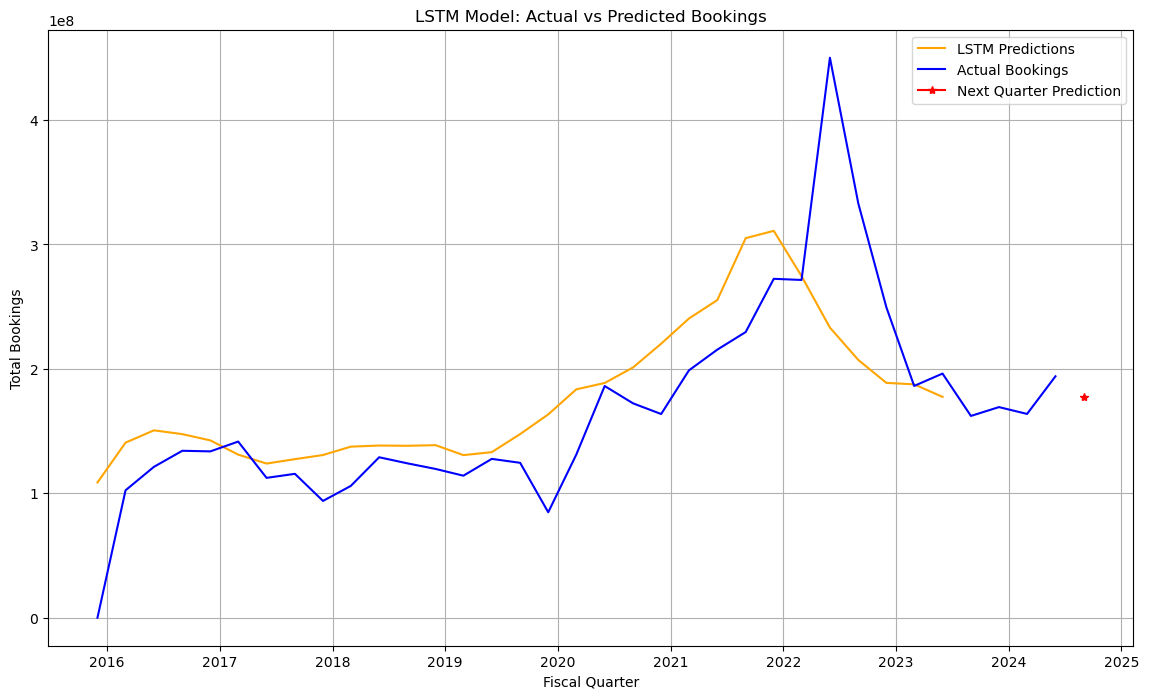

Next Quarter Prediction: $177,508,896.00
Mean Absolute Error (MAE): $39,663,414.74
Mean Absolute Percentage Error (MAPE): 1578961332024540804415488.00%
R-squared (R2): 0.497


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

def load_and_prepare_data():
    """
    Load and prepare the revenue forecast data for LSTM time series analysis.
    Includes date conversion and sorting for sequential processing.
    
    Returns:
        DataFrame: Processed dataset with datetime features
    """
    # Load raw data from CSV file
    df = pd.read_csv('Revenue Forecast.csv')
    
    # Extract quarter (1-4) and year from fiscal quarter name
    df['QUARTER'] = df['FISCAL_YEAR_QUARTER_NAME'].str[-1].astype(int)
    df['YEAR'] = df['FISCAL_YEAR_QUARTER_NAME'].str[2:4].astype(int)
    
    # Convert fiscal quarters to datetime format for proper sequential ordering
    # Example: 'FY22Q1' -> '2022-03-01' (Q1=month 3, Q2=month 6, etc.)
    df['FISCAL_QUARTER'] = pd.to_datetime(df['FISCAL_YEAR_QUARTER_NAME'].apply(
        lambda x: f"20{x[2:4]}-{(int(x[-1]) * 3):02d}-01"
    ))
    
    # Sort chronologically for sequential analysis
    df = df.sort_values('FISCAL_QUARTER')
    
    return df

def create_quarterly_features_lstm(df):
    """
    Aggregate data to quarterly level for LSTM modeling.
    
    Args:
        df: Raw DataFrame with multiple entries per quarter
        
    Returns:
        DataFrame: Aggregated quarterly data with datetime index
    """
    # Sum bookings by fiscal quarter
    quarterly_df = df.groupby('FISCAL_YEAR_QUARTER_NAME')['FISCAL_QUARTER_BKGS_AMT'].sum().reset_index()
    quarterly_df = quarterly_df.rename(columns={'FISCAL_QUARTER_BKGS_AMT': 'total_bookings'})
    
    # Convert fiscal quarters to datetime for sequential ordering
    quarterly_df['fiscal_quarter'] = pd.to_datetime(
        quarterly_df['FISCAL_YEAR_QUARTER_NAME'].apply(lambda x: f"20{x[2:4]}-{(int(x[-1]) * 3):02d}-01")
    )
    quarterly_df = quarterly_df.sort_values('fiscal_quarter')
    
    return quarterly_df

def prepare_data_for_lstm(quarterly_df, n_steps=4):
    """
    Prepare sequential data for LSTM model by creating sliding windows of historical data.
    
    Args:
        quarterly_df: DataFrame with quarterly bookings
        n_steps: Number of historical quarters to use for prediction (window size)
        
    Returns:
        tuple: (X sequences, y targets, scaler object for inverse transformation)
    """
    # Reshape data for scaling (required shape: [n_samples, n_features])
    data = quarterly_df['total_bookings'].values.reshape(-1, 1)
    
    # Scale data to [0,1] range for better LSTM performance
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    # Create sequences for LSTM (sliding window approach)
    X, y = [], []
    for i in range(len(data) - n_steps):
        # X: sequences of n_steps quarters
        X.append(data[i:i + n_steps])
        # y: target is the next quarter after the sequence
        y.append(data[i + n_steps])
    
    # Convert to numpy arrays and reshape for LSTM input
    X = np.array(X)  # Shape: [samples, time steps, features]
    y = np.array(y)  # Shape: [samples, features]
    return X, y, scaler

def build_and_train_lstm(X, y, epochs=100, batch_size=8):
    """
    Create and train LSTM neural network for time series prediction.
    
    Args:
        X: Input sequences
        y: Target values
        epochs: Number of training iterations
        batch_size: Number of samples per gradient update
        
    Returns:
        trained LSTM model
    """
    # Define sequential model architecture
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),  # LSTM layer with 50 units
        Dense(1)  # Output layer for single step prediction
    ])
    
    # Compile model with Adam optimizer and MSE loss
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

def predict_next_quarter(model, scaler, X, n_steps=4):
    """
    Generate prediction for the next quarter using trained LSTM model.
    
    Args:
        model: Trained LSTM model
        scaler: Fitted MinMaxScaler object
        X: Input sequences
        n_steps: Sequence length
        
    Returns:
        float: Predicted booking value for next quarter
    """
    # Get the most recent sequence
    last_sequence = X[-1]
    
    # Generate prediction (scaled)
    next_quarter_prediction_scaled = model.predict(last_sequence.reshape(1, n_steps, 1))
    
    # Inverse transform the scaled prediction
    next_quarter_prediction = scaler.inverse_transform(next_quarter_prediction_scaled)
    return next_quarter_prediction[0][0]

def plot_lstm_results(quarterly_df, predictions, next_quarter_prediction):
    """
    Visualize LSTM model results including historical predictions and next quarter forecast.
    
    Args:
        quarterly_df: Historical data
        predictions: Model's historical predictions
        next_quarter_prediction: Forecast for next quarter
    """
    plt.figure(figsize=(14, 8))
    
    # Plot historical predictions and actual values
    plt.plot(quarterly_df['fiscal_quarter'][:len(predictions)], predictions, 
             label='LSTM Predictions', color='orange')
    plt.plot(quarterly_df['fiscal_quarter'], quarterly_df['total_bookings'], 
             label='Actual Bookings', color='blue')
    
    # Add next quarter prediction point
    next_quarter_date = quarterly_df['fiscal_quarter'].iloc[-1] + pd.DateOffset(months=3)
    plt.plot(next_quarter_date, next_quarter_prediction, marker='*', 
             color='red', label='Next Quarter Prediction')
    
    # Customize plot appearance
    plt.title("LSTM Model: Actual vs Predicted Bookings")
    plt.xlabel("Fiscal Quarter")
    plt.ylabel("Total Bookings")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Next Quarter Prediction: ${next_quarter_prediction:,.2f}")

def evaluate_lstm(quarterly_df, predictions):
    """
    Calculate and display performance metrics for the LSTM model.
    
    Args:
        quarterly_df: Historical actual values
        predictions: Model predictions
    """
    # Calculate error metrics on historical predictions
    actuals = quarterly_df['total_bookings'][:len(predictions)]
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    r2 = r2_score(actuals, predictions)
    
    # Display metrics
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2): {r2:.3f}")

def main():
    """
    Main execution function that orchestrates the LSTM modeling process.
    """
    # Step 1: Load and prepare data
    df = load_and_prepare_data()
    quarterly_df = create_quarterly_features_lstm(df)
    
    # Step 2: Prepare sequences for LSTM
    n_steps = 4  # Use 4 quarters of history for prediction
    X, y, scaler = prepare_data_for_lstm(quarterly_df, n_steps)
    
    # Step 3: Build and train LSTM model
    model = build_and_train_lstm(X, y, epochs=100, batch_size=8)
    
    # Step 4: Generate historical predictions
    predictions_scaled = model.predict(X)
    predictions = scaler.inverse_transform(predictions_scaled).flatten()
    
    # Step 5: Predict next quarter
    next_quarter_prediction = predict_next_quarter(model, scaler, X, n_steps)
    
    # Step 6: Visualize results
    plot_lstm_results(quarterly_df, predictions, next_quarter_prediction)
    
    # Step 7: Evaluate model performance
    evaluate_lstm(quarterly_df, predictions)

if __name__ == "__main__":
    main()

#### Implementing a train_test_split for lstm

Loading data...
Training model...
Epoch 1/100


C:\Users\lodarih\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1558
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0850
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0869
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0633  
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0630
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0406 
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188 
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 

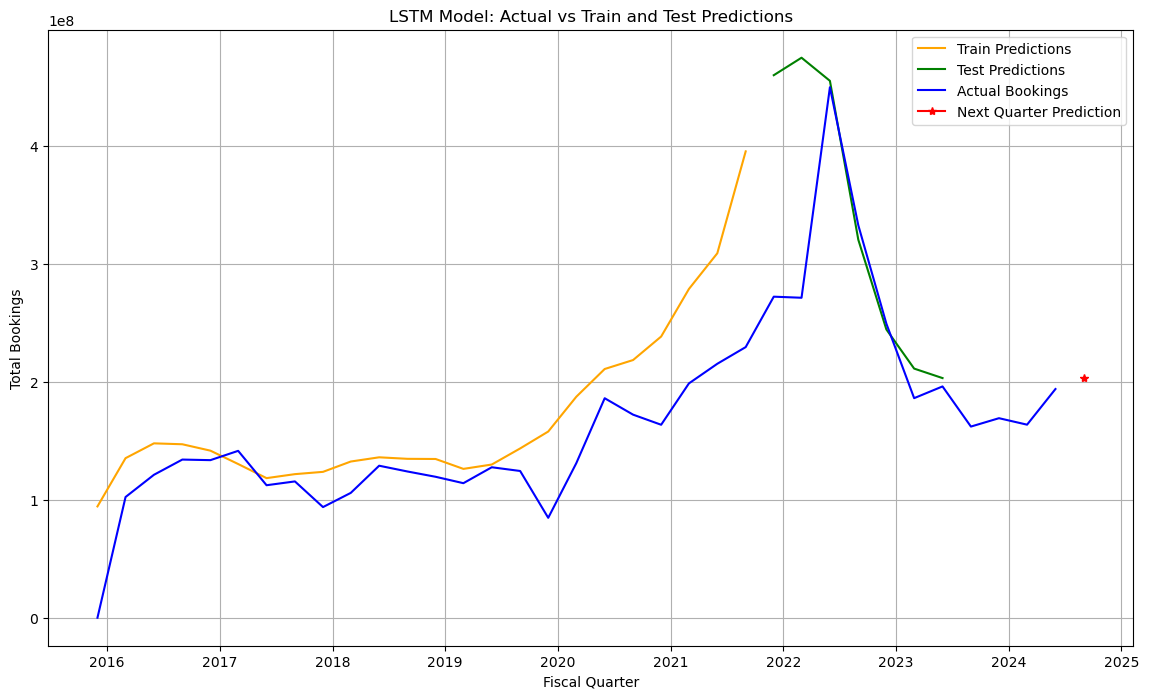

Next Quarter Prediction: $203,329,152.00

Model Performance on Test Set:
Mean Absolute Error (MAE): $63,764,147.57
Mean Absolute Percentage Error (MAPE): 23.99%
R-squared (R2): -0.598


In [12]:
from sklearn.model_selection import train_test_split

def prepare_data_for_lstm_with_split(quarterly_df, n_steps=4, test_size=0.2):
    """
    Prepare sequential data for LSTM model with train-test split for validation.
    
    Args:
        quarterly_df: DataFrame with quarterly bookings
        n_steps: Number of historical quarters to use for prediction (window size)
        test_size: Proportion of data to use for testing (0.2 = 20%)
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test, scaler)
            - Training and testing sequences
            - Training and testing targets
            - Fitted scaler for inverse transformation
    """
    # Reshape data for scaling (required shape: [n_samples, n_features])
    data = quarterly_df['total_bookings'].values.reshape(-1, 1)
    
    # Scale data to [0,1] range for better LSTM performance
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    # Create sequences for LSTM using sliding window approach
    X, y = [], []
    for i in range(len(data) - n_steps):
        # X: sequence of n_steps quarters
        X.append(data[i:i + n_steps])
        # y: target is the next quarter after sequence
        y.append(data[i + n_steps])
    
    # Convert to numpy arrays
    X = np.array(X)  # Shape: [samples, time steps, features]
    y = np.array(y)  # Shape: [samples, features]
    
    # Split data into training and testing sets
    # shuffle=False maintains temporal order of sequences
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test, scaler

def main():
    """
    Main execution function with train-test split for model validation.
    Includes separate visualization of training and testing predictions.
    """
    # Step 1: Load and prepare data
    print("Loading data...")
    df = load_and_prepare_data()
    quarterly_df = create_quarterly_features_lstm(df)
    
    # Step 2: Prepare sequences with train-test split
    n_steps = 4  # Use 4 quarters of history for prediction
    X_train, X_test, y_train, y_test, scaler = prepare_data_for_lstm_with_split(
        quarterly_df, n_steps, test_size=0.2
    )
    
    # Step 3: Build and train LSTM model on training data only
    print("Training model...")
    model = build_and_train_lstm(X_train, y_train, epochs=100, batch_size=8)
    
    # Step 4: Generate predictions for training data
    train_predictions_scaled = model.predict(X_train)
    train_predictions = scaler.inverse_transform(train_predictions_scaled).flatten()
    
    # Step 5: Generate predictions for test data (out-of-sample)
    test_predictions_scaled = model.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()
    
    # Step 6: Generate next quarter prediction using most recent data
    next_quarter_prediction = predict_next_quarter(model, scaler, X_test, n_steps)
    
    # Step 7: Visualize results showing train and test predictions separately
    plt.figure(figsize=(14, 8))
    
    # Plot training predictions
    plt.plot(
        quarterly_df['fiscal_quarter'][:len(train_predictions)],
        train_predictions,
        label='Train Predictions',
        color='orange'
    )
    
    # Plot test predictions
    plt.plot(
        quarterly_df['fiscal_quarter'][len(train_predictions):len(train_predictions) + len(test_predictions)],
        test_predictions,
        label='Test Predictions',
        color='green'
    )
    
    # Plot actual values
    plt.plot(
        quarterly_df['fiscal_quarter'],
        quarterly_df['total_bookings'],
        label='Actual Bookings',
        color='blue'
    )
    
    # Add next quarter prediction point
    next_quarter_date = quarterly_df['fiscal_quarter'].iloc[-1] + pd.DateOffset(months=3)
    plt.plot(
        next_quarter_date,
        next_quarter_prediction,
        marker='*',
        color='red',
        label='Next Quarter Prediction'
    )
    
    # Customize plot appearance
    plt.title("LSTM Model: Actual vs Train and Test Predictions")
    plt.xlabel("Fiscal Quarter")
    plt.ylabel("Total Bookings")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print next quarter prediction
    print(f"Next Quarter Prediction: ${next_quarter_prediction:,.2f}")
    
    # Step 8: Evaluate model performance on test set only
    print("\nModel Performance on Test Set:")
    evaluate_lstm(
        quarterly_df.iloc[len(train_predictions):len(train_predictions) + len(test_predictions)],
        test_predictions
    )

# Script entry point
if __name__ == "__main__":
    main()